<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Instructions" data-toc-modified-id="Instructions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Instructions</a></span></li><li><span><a href="#Import" data-toc-modified-id="Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Synthetic-data" data-toc-modified-id="Synthetic-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Synthetic data</a></span></li><li><span><a href="#Real-data" data-toc-modified-id="Real-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Real data</a></span></li><li><span><a href="#Kd-trees" data-toc-modified-id="Kd-trees-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Kd trees</a></span></li><li><span><a href="#Questions" data-toc-modified-id="Questions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Questions</a></span></li></ul></div>

# IA317: Large-scale machine learning
# Tree search

In this lab, you will learn to work with [kd-trees](https://en.wikipedia.org/wiki/K-d_tree), in particular to build the graph of nearest neighbors.<br>
You will find below a function to build a kd-tree and to find the nearest neighbor of some target using this data structure.

## Instructions

Please provide short answers to the questions at the bottom of the notebook. Most involve Python coding. Add as many cells as necessary (code and text). You might test your code using synthetic data.

Before uploading your notebook on [eCampus](https://ecampus.paris-saclay.fr/course/view.php?id=18426), please:
* Delete all useless cells (tests, etc.)
* Check that **your code is running and does not produce any errors**. You might restart the kernel and run all cells at the end of the lab to check that this is indeed the case. 
* Keep the outputs.

The deadline is **Thursday, December 18th (midnight).**

## Import

In [1]:
import numpy as np

In [2]:
from scipy import sparse

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

In [5]:
import time

## Synthetic data

In [6]:
# Standard Gaussian model
X_synthetic = np.random.normal(size = (1000000,2))

## Real data

We will use a dataset providing the GPS coordinates of the ~13,000 largest cities of the world. For simplicity, we will use the Euclidean distance on the world map, with coordinates = (longitude, latitude).

In [7]:
# First download the file
cities = pd.read_csv('worldcities.csv')

In [8]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


In [9]:
names = list(cities['city'])
admin_names = list(cities['admin_name'])
lat = list(cities['lat'])
long = list(cities['lng'])

In [10]:
X = np.vstack((long,lat)).T

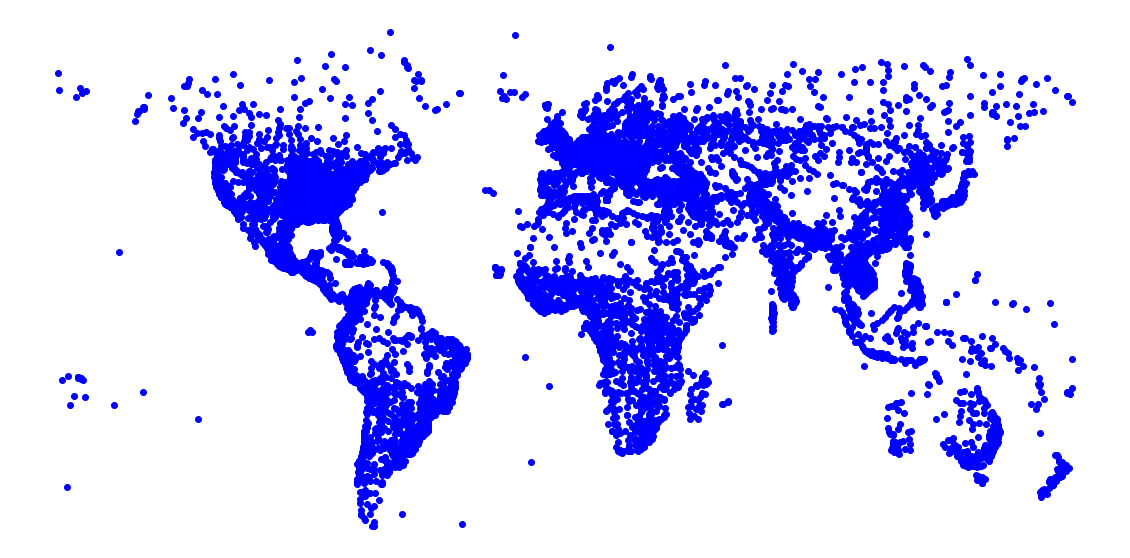

In [11]:
plt.figure(figsize = (20,10))
_ = plt.scatter(X[:,0], X[:,1], c='b')
_ = plt.axis('off')

## Kd trees

In [140]:
class KD_Tree:
    def __init__(self, index, ancestor, mins, maxs):
        self.index = index
        self.ancestor = ancestor
        self.mins = mins
        self.maxs = maxs
        self.direction = None        
        self.pivot = None
        self.left = None
        self.right = None

In [13]:
def split(X, index, method):
    '''Split method (max spread or max variance)
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray
        Sample indices, within range(n_samples)
    method : str, 'maxspread' or 'maxvariance'
        Method 
        
    Returns
    -------
    k : int
        Direction, in range(n_features)
    i : int
        Pivot, in range(n_samples)
    '''
    if method == 'maxspread':
        # max spread
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
        k = np.argmax(maxs - mins)
        middle = (maxs[k] + mins[k]) / 2
        i = index[np.argmin(np.abs(X[index,k] - middle))]
    else:
        # max variance
        k = np.argmax(np.std(X[index], axis = 0))
        i = index[np.argsort(X[index,k])[len(index) // 2]]
    return k, i

In [14]:
def build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread'):
    '''Build the kd-tree from data.
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray or None
        Sample indices, within range(n_samples)
    ancestor : KD_Tree or None
        Ancestor of the current node
    mins : np.ndarray or None
        Min values of the rectangle, shape (n_features,)
    maxs : np.ndarray
        Max values of the rectangle, shape (n_features,)
    leaf_size : int
        Leaf size of the kd-tree 
    method : str, 'maxspread' or 'maxvariance'
        Split method 
        
    Returns
    -------
    tree : KD_Tree
        kd-tree
    '''
    if index is None:
        index = np.arange(X.shape[0])
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
    tree = KD_Tree(index, ancestor, mins, maxs)
    if len(index) > leaf_size:
        k,i = split(X, index, method)
        tree.direction, tree.pivot = k, i
        index = np.array(list(set(index) - {i}))
        index_left = index[np.where(X[index,k] <= X[i,k])[0]]
        maxs_ = maxs.copy()
        maxs_[k] = X[i,k]
        tree.left = build_kd_tree(X, index_left, tree, mins, maxs_, leaf_size, method)
        index_right = index[np.where(X[index,k] > X[i,k])[0]]
        mins_ = mins.copy()
        mins_[k] = X[i,k]        
        tree.right = build_kd_tree(X, index_right, tree, mins_, maxs, leaf_size, method)
    return tree

In [15]:
def search_leaf(x, X, tree):
    '''Search the leaf node of the kd-tree given some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    tree : KD_Tree
        Leaf node
    '''
    if tree.pivot is not None:
        k = tree.direction
        i = tree.pivot
        if x[k] <= X[i,k]:
            return search_leaf(x, X, tree.left)
        else:
            return search_leaf(x, X, tree.right)
    else:
        return tree

In [16]:
def nn_search_kd_tree(x, X, tree):
    '''Search the nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    nn : int
        Index of the nearest neighbor
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    nn = None
    if len(index):
        nn = index[np.argmin(np.linalg.norm(X[index] - x, axis = 1))]
        dist = np.linalg.norm(X[nn] - x)
    
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if nn is None or np.linalg.norm(X[node.pivot] - x) < dist:
            nn = node.pivot
            dist = np.linalg.norm(X[nn] - x)
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < dist)
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                nn_ = nn_search_kd_tree(x, X, tree_)
                dist_ = np.linalg.norm(X[nn_] - x)
                if dist_ < dist:
                    nn, dist = nn_, dist_
                tree_.ancestor = ancestor
    return nn

## Questions

1. What is the closest city from the [Null Island](https://fr.wikipedia.org/wiki/Null_Island) (provide the name)?

In [184]:
#Null Island is an imaginary island whose coordinates are (0,0)
Null_Island = [0,0]
tree = build_kd_tree(X=X)
leaf = nn_search_kd_tree(x=Null_Island, X=X, tree=tree)
print("The nearest neighboor of Null Island is "+names[leaf])

The nearest neighboor of Null Island is Sekondi


2. What are the 10 closest cities from Paris (provide the names)?<br>
Choose the true Paris :-)

In [18]:
def k_nn_search_kd_tree(x, X, tree, k):
    '''Search the k nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
    k : int
        Number of nearest neighboors to return 
        
    Returns
    -------
    k_nn : numpy array
        Indexes of the k nearest neighbor
    k_dist : numpy array
        Distances between Target and k_nn
    
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    k_nn = None
    if len(index):  
        norm = np.linalg.norm(X[index] - x, axis = 1)
        k_nn = index[np.argsort(norm)[0:k+1]]
        k_dist = [np.linalg.norm(X[k_nn[i]] - x) for i in range(len(k_nn))]
        
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if np.linalg.norm(X[node.pivot] - x) < k_dist[-1] or len(k_nn) < k+1 :
            norm = np.linalg.norm(X[node.pivot] - x)
            indexes = np.searchsorted(k_dist, norm)
            k_dist = np.insert(k_dist, indexes, norm)
            k_nn = np.insert(k_nn, indexes, node.pivot)
            #delete the last element of k_nn
            if len(k_nn) > k+1 :
                k_dist = np.delete(k_dist, -1, 0)
                k_nn = np.delete(k_nn, -1, 0)
                  
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = np.linalg.norm(x - y) < k_dist[-1]
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                k_nn_, k_dist_ = k_nn_search_kd_tree(x, X, tree_, k)
                #We concatenate the k_nn and k_dist of the 2 tree searches to easily sort the nearest neighboors by distance 
                K_nn = np.concatenate((k_nn, k_nn_))
                K_dist = np.concatenate((k_dist, k_dist_))
                tab = np.array([K_nn, K_dist])
                #We sort the ndarray according to the distances and select the k-nn
                tab = tab[:, tab[1].argsort()]
                #We select only the first k+1 cities
                k_nn, k_dist = tab[0][0:k+1].astype(int), tab[1][0:k+1]
                tree_.ancestor = ancestor
    return k_nn, k_dist

In [19]:
#Let's plot the ten nn of the True Paris
k = 10
Paris = admin_names.index("Île-de-France") 
Paris = [long[Paris], lat[Paris]]

start_t = time.time()
ten_nn_Paris , d_nn_Paris = k_nn_search_kd_tree(Paris, X, tree, k)
end_t = time.time()

ten_nn_Paris = [names[ten_nn_Paris[i]] for i in range(len(ten_nn_Paris))][1:k+1]
print("The ten nearest neighboors of Paris are : "+str(ten_nn_Paris))
print("At the respectives distances : "+str(d_nn_Paris[1:k+1]))
print("Execution time : "+str(end_t - start_t))

The ten nearest neighboors of Paris are : ['Versailles', 'Melun', 'Amiens', 'Orléans', 'Rouen', 'Arras', 'Auxerre', 'Dieppe', 'Reims', 'Bourges']
At the respectives distances : [0.2106714  0.4714281  1.03423623 1.05900169 1.37423382 1.48635647
 1.63034493 1.64346859 1.73954493 1.78424715]
Execution time : 0.005506038665771484


3. Compare the previous search time to a brute force approach (with default leaf size = 30).

In [20]:
#Brute force approach
start_t = time.time()

#Just compute the distance between Paris and every other cities
index = np.arange(X.shape[0])
dist = np.array([np.linalg.norm(X[i] - Paris) for i in range(X.shape[0])])
tab = np.array([index, dist])
#Sort the index by distance to Paris
nn = tab[:,  np.argsort(tab[1])]
ten_nn = np.array(nn[0][1:11], dtype=int)
#Get the ten nn excluding Paris itself
dis_ten_nn = nn[1][1:11]
end_t = time.time()

print("The ten nearest neighboors of Paris are : "+str([names[ten_nn[i]] for i in range(len(ten_nn))]))
print("At the respectives distances : "+str(dis_ten_nn))
print("Execution time : "+str(end_t - start_t))

The ten nearest neighboors of Paris are : ['Versailles', 'Melun', 'Amiens', 'Orléans', 'Rouen', 'Arras', 'Auxerre', 'Dieppe', 'Reims', 'Bourges']
At the respectives distances : [0.2106714  0.4714281  1.03423623 1.05900169 1.37423382 1.48635647
 1.63034493 1.64346859 1.73954493 1.78424715]
Execution time : 0.20291590690612793


The Kd tree search algorithm is approximately __4 times quicker__ to run than the brute force algorithm for 13.000 samples

4. Do the same comparison for synthetic data (with $10^6$ samples for instance). Comment.

In [21]:
#Let's rebuild the tree with the synthetic datas
tree_synthetic = build_kd_tree(X=X_synthetic)

In [22]:
#Kd_Tree search
k = 10
#Get a random index from X_synthetic
rand_pt = X_synthetic[np.random.choice(len(X_synthetic))]

start_t = time.time()
ten_nn , d_nn = k_nn_search_kd_tree(rand_pt, X_synthetic, tree_synthetic, k)
end_t = time.time()

ten_nn = [ten_nn[i] for i in range(len(ten_nn))][1:k+1]
print("The ten nearest neighboors of the random point are : "+str(ten_nn))
print("At the respectives distances : "+str(d_nn))
print("Execution time : "+str(end_t - start_t))

The ten nearest neighboors of the random point are : [514598, 264071, 658555, 360623, 691338, 86299, 150982, 893372, 962511, 230941]
At the respectives distances : [0.         0.00231382 0.00271042 0.00300724 0.00318502 0.00332685
 0.00343238 0.00383698 0.00421902 0.00452162 0.00455144]
Execution time : 0.005280017852783203


In [23]:
#Brute force approach
start_t = time.time()

#Just compute the distance between the random point and every other cities
index = np.arange(X_synthetic.shape[0])
dist = np.array([np.linalg.norm(X_synthetic[i] - rand_pt) for i in range(X_synthetic.shape[0])])
tab = np.array([index, dist])
#Sort the index by distance to the random point
nn = tab[:,  np.argsort(tab[1])]
ten_nn = np.array(nn[0][1:11], dtype=int)
#Get the ten nn excluding Paris itself
dis_ten_nn = nn[1][1:11]
end_t = time.time()

print("The ten nearest neighboors of the random point are : " +str([ten_nn[i] for i in range(len(ten_nn))]))
print("At the respectives distances : "+str(dis_ten_nn))
print("Execution time : "+str(end_t - start_t))

The ten nearest neighboors of the random point are : [514598, 264071, 658555, 360623, 691338, 86299, 150982, 893372, 962511, 230941]
At the respectives distances : [0.00231382 0.00271042 0.00300724 0.00318502 0.00332685 0.00343238
 0.00383698 0.00421902 0.00452162 0.00455144]
Execution time : 7.86832594871521


With 1.000.000 of random datas, the Kd search algorithm is now approximately **1600 times quicker** than the brute force algorithm. We see here that the complexity in time of these 2 searches are different and can cause a huge difference in the execution time.

__The Kd search is much more time efficient__.

5. What is the depth of the leaf node containing Paris in the kd-tree?<br>
Test various leaf sizes (e.g., 1, 10, 100, ...) and comment.

In [24]:
leaf_sizes = [1, 5, 10, 30, 50, 100, 500, 1000]

for i in range(len(leaf_sizes)):
    depth = 0
    #Build the Kd_Tree with different leaf sizes
    tree = build_kd_tree(X, leaf_size=leaf_sizes[i])
    #Get the leaf containing Paris
    leaf = search_leaf(Paris, X, tree) 
    #Just go back from the leaf to the root of the tree with the ancestor method
    while(leaf != None):
        leaf = leaf.ancestor
        depth += 1
    print("\nSize of the leafs in the tree : "+str(leaf_sizes[i]))
    #Do not count the last iteration in the depth counter
    print("The depth of the leaf node containing Paris in the Kd_Tree is : "+str(depth-1))


Size of the leafs in the tree : 1
The depth of the leaf node containing Paris in the Kd_Tree is : 15

Size of the leafs in the tree : 5
The depth of the leaf node containing Paris in the Kd_Tree is : 13

Size of the leafs in the tree : 10
The depth of the leaf node containing Paris in the Kd_Tree is : 12

Size of the leafs in the tree : 30
The depth of the leaf node containing Paris in the Kd_Tree is : 11

Size of the leafs in the tree : 50
The depth of the leaf node containing Paris in the Kd_Tree is : 10

Size of the leafs in the tree : 100
The depth of the leaf node containing Paris in the Kd_Tree is : 10

Size of the leafs in the tree : 500
The depth of the leaf node containing Paris in the Kd_Tree is : 8

Size of the leafs in the tree : 1000
The depth of the leaf node containing Paris in the Kd_Tree is : 6


When the leaf size is small, the tree is pretty deep. When the leaf size is big, the tree is shallow. 

In fact smaller the leaf size is, deeper the tree is.

6. Build the graph of 3-nearest neighbors. You must return the adjacency matrix of the graph in the sparse format of your choice. How many connected components are there in this graph, considered as undirected (check [this](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.connected_components.html))? Show the 3 largest connected components on the map. 

In [25]:
#Be careful, long time running cell
#Compute the 3-nn of every city in the world and store it in lists
tree = build_kd_tree(X)
k = 3
mtx = sparse.dok_matrix((len(X), len(X)), dtype=np.int64)
#Let's fill the sparse matrix with the 3 nn of each cities
for i in range(len(X)):
    city = [long[i], lat[i]]
    k_nn = k_nn_search_kd_tree(city, X, tree, k=k)[0][1:k+1]
    for j in range(len(k_nn)):
        mtx[i, k_nn[j]] = 1

#Compute the connected components of our graph
n_components, labels = sparse.csgraph.connected_components(csgraph=mtx, directed=False, return_labels=True)
print("The graph contains "+str(n_components) + " connected components")

The graph contains 65 connected components


In [26]:
#Get the indices of the cities belongings to the 3 largest connected components
index = np.arange(X.shape[0])

#Count how many times a label appear in the labels vector
c_c = np.zeros(len(X))
for label in labels:
    c_c[label] += 1

#Sort the array based on number of times a label appear
tab = np.array([index, c_c], dtype=int)
#Get the 3 largest connected components and the number of elements in each of them
tab = tab[:, np.argsort(tab[1])][:, -3:]
largest_labels = tab[0]
nb_labels = tab[1]

#Get the 3 largest clusters
X3 = np.where([labels == largest_labels[0]])[1]
X2 = np.where([labels == largest_labels[1]])[1]
X1 = np.where([labels == largest_labels[2]])[1]

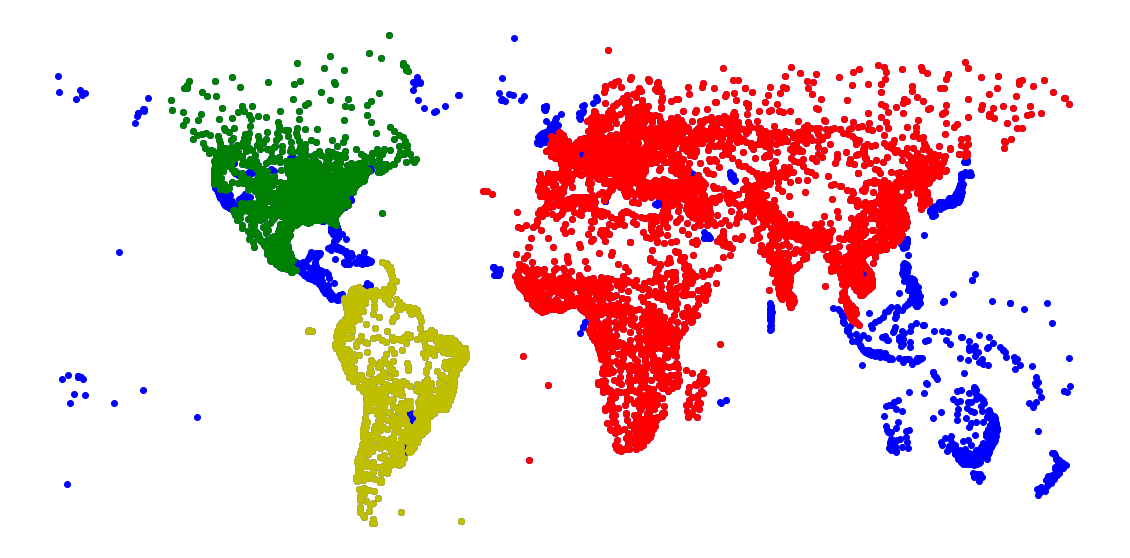

In [27]:
#Let's plot the 3 largest connected components
plt.figure(figsize = (20,10))
_ = plt.scatter(X[:,0], X[:,1], c='b')
_ = plt.scatter([long[X1[i]] for i in range(len(X1))], [lat[X1[i]] for i in range(len(X1))], c='r')
_ = plt.scatter([long[X2[i]] for i in range(len(X2))], [lat[X2[i]] for i in range(len(X2))], c='g')
_ = plt.scatter([long[X3[i]] for i in range(len(X3))], [lat[X3[i]] for i in range(len(X3))], c='y')
_ = plt.axis('off')

7. (optional) Code the nearest neighbor search with a ball tree and compare the performance with kd-trees.

In [149]:
#Let's define the Ball_Tree class just as Kd_Tree
class Ball_Tree:
    def __init__(self, index, ancestor, mins, maxs):
        self.index = index
        self.ancestor = ancestor
        self.radius = None
        self.direction = None 
        self.mins = mins
        self.maxs = maxs
        self.pivot = None
        self.left = None
        self.right = None

In [163]:
def build_ball_tree(X, index = None, ancestor = None, leaf_size = 30, mins = None, maxs = None, method = 'maxspread'):
    '''Build the ball-tree from data.
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray or None
        Sample indices, within range(n_samples)
    ancestor : KD_Tree or None
        Ancestor of the current node
    leaf_size : int
        Leaf size of the kd-tree 
    method : str, 'maxspread' or 'maxvariance'
        Split method 
        
    Returns
    -------
    tree : Ball_Tree
        ball-tree
    '''
    if index is None:
        index = np.arange(X.shape[0])
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
        
    tree = Ball_Tree(index, ancestor, mins, maxs)
    if len(index) > leaf_size:
        k,i = split(X, index, method)
        tree.direction, tree.pivot = k, i
        index = np.array(list(set(index) - {i}))
        #Compute the farthest point from pivot i
        farthest = [sum(np.abs(X[i] - X[j])) for j in index]
        max_dis = index[np.where([sum(np.abs(X[i] - X[j])) == max(farthest) for j in index])]    
        tree.radius = np.linalg.norm(X[i] - X[max_dis])
        
        index_left = index[np.where(X[index,k] <= X[i,k])[0]]
        maxs_ = maxs.copy()
        maxs_[k] = X[i,k]
        tree.left = build_ball_tree(X, index_left, tree, leaf_size, mins, maxs_, method)
        index_right = index[np.where(X[index,k] > X[i,k])[0]]
        mins_ = mins.copy()
        mins_[k] = X[i,k]        
        tree.right = build_ball_tree(X, index_right, tree, leaf_size, mins_, maxs, method)
    return tree

In [168]:
ball_tree = build_ball_tree(X)

In [177]:
def nn_search_ball_tree(x, X, tree):
    '''Search the nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : Ball_Tree
        ball-tree
        
    Returns
    -------
    nn : int
        Index of the nearest neighbor
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    nn = None
    if len(index):
        nn = index[np.argmin(np.linalg.norm(X[index] - x, axis = 1))]
        dist = np.linalg.norm(X[nn] - x)
    
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if nn is None or np.linalg.norm(X[node.pivot] - x) < dist:
            nn = node.pivot
            dist = np.linalg.norm(X[nn] - x)
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < dist)
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                nn_ = nn_search_kd_tree(x, X, tree_)
                dist_ = np.linalg.norm(X[nn_] - x)
                if dist_ < dist :
                    nn, dist = nn_, dist_
                tree_.ancestor = ancestor
    return nn

In [190]:
nn = nn_search_ball_tree(Null_Island, X, ball_tree)
print(names[nn])

#from sklearn.neighbors import BallTree
#ball_tree = BallTree(X, leaf_size=30)

Sekondi
